In [ ]:
#SCRIPT PRA ACESSAR DADOS DE PRECIPITAÇÃO TOTAL

Primeiramente vamos importar as bibliotecas necessárias para que o script consiga ser rodado. Neste script vamos utilizar 
as seguintes bibliotecas, com o site onde se pode obter informações sobre a mesma. 
    xarray: https://docs.xarray.dev/en/stable/index.html
    matplotlib: https://matplotlib.org/stable/
    numpy: https://numpy.org/
    cartopy: https://scitools.org.uk/cartopy/docs/latest/
    scipy: https://scipy.org/
    ecmwf.opendata: https://confluence.ecmwf.int/display/WEBAPI/Access+MARS

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from scipy.ndimage.filters import maximum_filter, minimum_filter
import scipy.ndimage as ndimage
from ecmwf.opendata import Client

In [13]:
# AQUI VAMOS DEFINIR UM MÉTODO PRA OBTER OS VALORES MÁXIMOS DE PRECIPITAÇÃO, PODE SER USADO EM QUALQUER VARIÁVEL

def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):

        txt2 = ax.annotate('\n' + str(int(data[mxy[i], mxx[i]])), xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]),
                           xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), 
                color=color, size=12, clip_on=True, annotation_clip=True, fontweight='bold', 
                           horizontalalignment='center', verticalalignment='top',
                transform=ccrs.PlateCarree())  

In [3]:
# O ACESSO AOS DADOS SERÁ FEITO DA SEGUINTE FORMA:

from ecmwf.opendata import Client
#client = Client("ecmwf", beta=True)
client = Client()
client.retrieve(
    date=20231001, # data da inicialização do modelo
    time=0,       # hora da rodada do modelo
    step=180,      # hora analisada, neste caso 180h, mas pode ser efetuado em até 240h
    stream="oper",
    type="fc",
    levtype="sfc",
    param="tp",
    target="data.grib2" # formato a ser salvo o arquivo
)

20231001000000-180h-oper-fc.grib2:   0%|          | 0.00/423k [00:00<?, ?B/s]

In [4]:
# COM O XARRAY SERÁ REALIZADO A LEITURA DO ARQUIVO

ds=xr.open_dataset("data.grib2", engine="cfgrib")
ds

Ignoring index file 'data.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  datetime64[ns] ...
Data variables:
    tp          (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-01T21:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
# DEFININDO O TÍTULO DA IMAGEM

title='Inic 00UTC 01/10  Valid 12UTC 08/10'
title1='ECMWF_pt_V08_10'

In [6]:
# EXTRAINDO OS DADOS DO ARQUIVO, NO CASO A LONGITUDE, LATITUDE, E A VARIÁVEL (PRECIPITAÇÃO TOTAL)

prec=ds['tp']*1000 # na variável da precipitação do ECMWF, preciso multiplicar por 1000, para obter a variável em mm
lon=ds['longitude']
lat=ds['latitude']

In [7]:
# CÓDIGO USADO PARA SUAVIZAR OS CONTORNOS DA PRECIPITAÇÃO

precP=ndimage.gaussian_filter(prec,sigma=.7,order=0)

In [8]:
# A função numpy.meshgrid é usada para criar uma grade retangular a partir de duas matrizes unidimensionais que representam 
# a indexação cartesiana ou a indexação matricial

lon,lat=np.meshgrid(prec.longitude,prec.latitude)

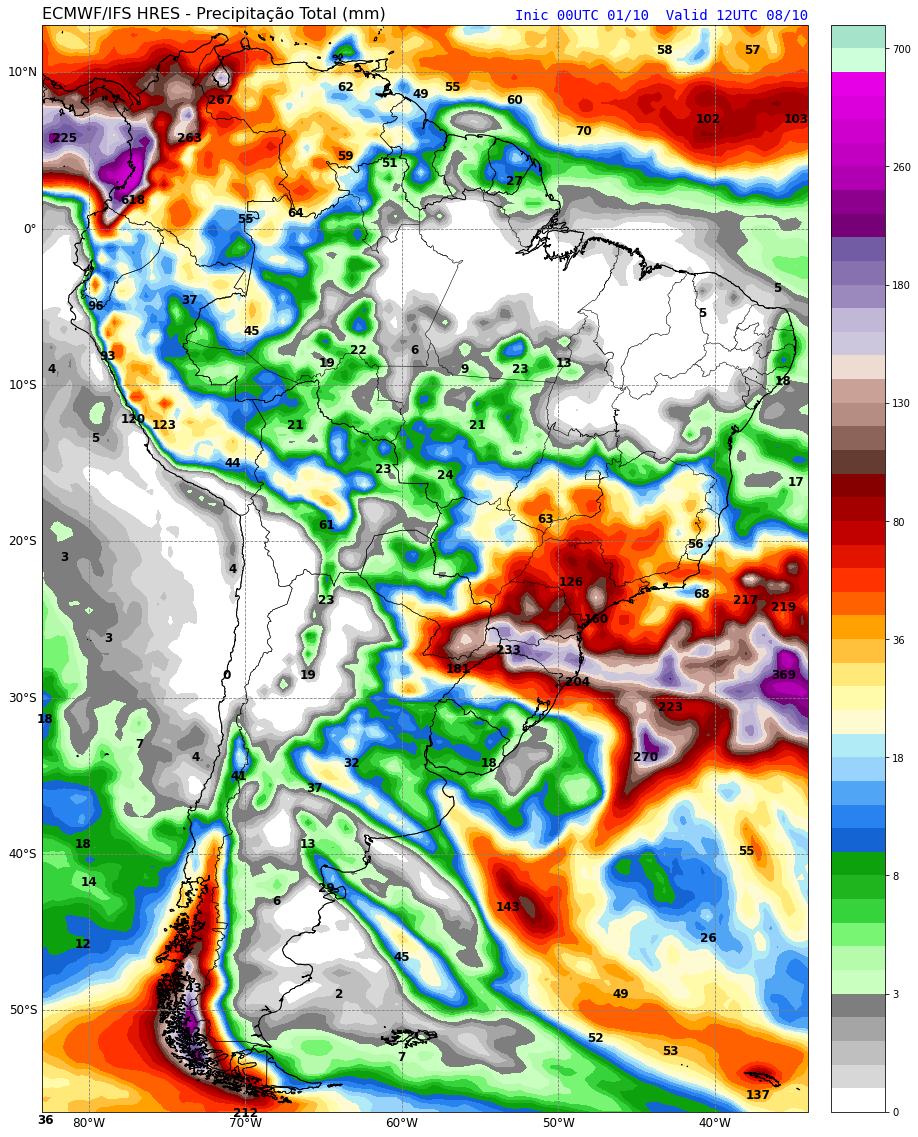

In [14]:
# Criando um objeto de figura para receber o mapa
fig = plt.figure(figsize=(20, 20))

# Criando um eixo com a projeção escolhida
ax = plt.axes(projection=ccrs.PlateCarree())

# Adicionando os limites do oceano
ax.coastlines(resolution="10m")

# Definindo a extensão da área a ser plotada
ax.set_extent([-83,-34,12,-54])
#ax.set_extent([-58,-47,-34,-22])

# Definindo a paleta personalizada de cores
cores=['#ffffff','#d7d7d7','#bfbfbf','#a5a5a5','#7e7e7e','#c9ffbf','#b5fbab','#78f572','#36d33c','#1eb51e','#0ea10e','#1464d3',
       '#2883f1','#50a5f5','#97d3fb','#b1ecf6','#fefbd2','#fffbab','#ffe978','#ffc13c','#ffa100','#ff6000','#ff3200','#e11400',
       '#c10000','#a50000','#870000','#643c32','#8d645a','#b58d83','#c9a197','#eedbd1','#cdc7dd','#c1b7d7','#9b89bd','#8772af',
       '#725ca3','#760076','#8d008d','#b100b1','#c100c1','#cd00cd','#db00db','#e500e5','#cdffdb','#a5e3ca']

# Definindo os valores mínimos e máximos correspondente a paleta 
levels=[0,0.5,1,1.5,2,3,4,5,6,7,8,10,12,14,16,18,20,24,28,32,36,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,
        220,240,260,300,400,500,600,700,800]

# Plotando os dado para a área especificada anteriormente 
im=ax.contourf(lon,lat,precP,levels=levels,
               colors=cores,
               transform=ccrs.PlateCarree())

# Plotando os valores máximo 
plot_maxmin_points(lon,lat,prec,'max',10,symbol='máx',
                   color='k',
                   transform=ccrs.PlateCarree())

# Adicionando os limites estaduais e mascarando outras áreas
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=.5)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=0.3)

# Adicionando linhas de grade
g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)

# Removendo os labels do topo e da direita
g1.right_labels=False
g1.top_labels=False

# Formatando os labels como latitude e longitude
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}


# Definindo a colorbar
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')

# Inserindo título
plt.title('ECMWF/IFS HRES - Precipitação Total (mm)',fontsize=16,loc='left')
plt.title(title,fontsize=14,loc='right',color='blue',fontweight='normal',fontfamily='monospace')

# Salvando a imagem
plt.savefig(title1+'.jpeg',dpi=300,bbox_inches='tight')